Short explanation about (the use of) the particle in cell method (PIC).
When simulating for example a plasma the Vlaslov equation, which describes a many body colissionless system, is often used to describe it's state. Particle simulations to describe physical systems such as plasma's or the solar system can generaly be done using one of three types of simulations: 1) PP method, 2) PIC method and 3) P^3M method. The first is best used in simulations where local forces between particles dominate and the number of particles to simulate is not very large, the second when long range forces are dominant and the latter is a mix of the two.
The code hereunder simulates a 1D plasma meaning motions of the particles are effected by the electric field they generate; "a long range force" problem.
By generating a grid of cells and treating all particles in a cell as one 'meta particle', computational costs can be reduced significantly (~N_p instead of ~(N_p)^2).
The effect a particle has on one or more cells is defined by it's shape (area of effect). I will use the most simple form: a 1d box with the same length as a cell.
Finally; the computational cycle for the PIC method is as follows:
1 update postions (particle mover) using for example the leap-frog method
2 assign particles to cells
3 compute electric fields for each cell
4 compute electric field on position of each particle
5 update velocities
Obviously in theory one can start at any step.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define some quantities

L= 2.0 * np.pi # box length
NT=2000 # total number of timesteps
NTOUT=25 # save output every other NTOUT
WP=1  
QM=- 1 # charge over mass (normalized). For electrons = -1
V0=0.0  # mean initial velocity (one for each species)
T=10**(-2)  # thermal velocity (standard deviation for a Maxwellian distribution)
XP1=0.001 # initial perturbation
mode=1


def PIC(N,NG,DT):
    """
    expect number of particles to simulate, number of gridpoints, timestep
    returns 7 arrays:
    particle vel, thermal vel, ini vel distr, electric E, kinetic E, total E, lin momentum
    """
    xp = np.linspace(0,L-L/N,N) # Initialize particles
    xp=xp + XP1 * np.sin(2 * np.pi * xp / L * mode) # Add a perturbation in the position (small displacement)
    vp = np.random.normal(V0, T, N) # velocity -> Normal distribution with std VT and mean V0
    # setting up useful arrays/lists
    thermal_vel = np.zeros(NT)
    P   = []
    W_E = []
    W_K = []
    E_T = []
    v0 = vp
    
    # main loop
    for i in range(NT):
        grid = np.zeros(NG) # resetting grid
        thermal_vel[i] = np.std(vp)
        # Mover --> Use leapfrog to update positions
        xp = xp + DT * vp

        # check for periodic boundary conditions
        for i in range(N):        
            if xp[i] > L:
                xp[i] = xp[i] - L
            if xp[i] < 0:
                xp[i] = L - np.abs(xp[i])
        

        # Accumulate density from Particles to Grid	(mind the BC)
        # and calculate charge density
        dx = L/NG  # b-spline (overlap is equal to width cell)
        wv = xp/dx # weighted particle charge
 
        # calculates charge per gridpoint
        for j in range(NG):
            for i in range(N):
                if wv[i] > float(j) and wv[i] <= float(j)+1.0:
                    grid[j] += wv[i]-float(j)

                    # adds weighted charge to neighboring cells
                    if wv[i] < (float(j) + float(j)+1.0)/2.0:
                        grid[j-1] += 1.0-(wv[i]-float(j))

                    if wv[i] >= (float(j) + float(j)+1.0)/2.0:
                        if j==NG-1:
                            grid[0] += 1.0-(wv[i]-float(j))
                        else:
                            grid[j+1] += 1.0-(wv[i]-float(j))


        # normalising to a charge density of unity, negative charge for electrons
        grid = -grid/N

        # adding background in the form of ions
        ion = 1.0/NG
        for i in range(NG):
            grid[i] += ion

        # creating matrix representation of Laplacian
        A = np.zeros((NG,NG))
        a,b = np.indices(A.shape)
        A[a==b]   = -2
        A[a==b-1] = 1
        A[a==b+1] = 1
        
        B = -(dx**2) * grid

        # computes Phi = A**(-1) B = electric potential at each grid
        Phi = np.linalg.solve(A,B)

        #print "Array of electric potentials :\n", Phi
        #print "Does A*Phi give back B?:", np.allclose(np.dot(A,Phi),B)

        # computes electrical field in each cell
        E_field = np.zeros(NG)
        for i in range(NG):
            if i==NG-1:
                E_field[i] = -(Phi[0] - Phi[i-1])/(2*dx)
            else:
                E_field[i] = -(Phi[i+1] - Phi[i-1])/(2*dx)

        #print "Electric field per cell : \n", E_field
        #print "Total electric field equal to zero? E_tot=", np.sum(E_field) 

        # calculates electric field on position of particles
        Ep = np.zeros(N)
        for j in range(NG):
            for i in range(N):
                if wv[i] > float(j) and wv[i] <= float(j)+1.0:

                    if wv[i] < (float(j) + float(j)+1.0)/2.0:
                        Ep[i] = (wv[i]-float(j))*E_field[j-1] + (1-(wv[i]-float(j)))*E_field[j]
                    if wv[i] >= (float(j) + float(j)+1.0)/2.0:
                        if j==NG-1:
                            Ep[i] = (wv[i]-float(j))*E_field[j] + (1-(wv[i]-float(j)))*E_field[0]
                        else:
                            Ep[i] = (wv[i]-float(j))*E_field[j] + (1-(wv[i]-float(j)))*E_field[j+1]

        #print "Electric field per particle :\n", Ep
        
        # total electric energy
        Ep2 = Ep**2
        Eps = np.sum(Ep2)
        W_E.append(Eps)

        # Update particle velocity with leapfrog
        vp = vp + QM * Ep * DT
        
        # total linear momentum
        P.append(np.sum(vp))
        
        # total kinetic energy
        vp2 = vp**2
        vps = np.sum(vp2)
        W_K.append(vps)
        
        # total energy
        et = Eps + vps
        E_T.append(et)
        
    return vp, thermal_vel, v0, W_E, W_K, E_T, P



In [ ]:
N  = [100, 500, 1000, 5000, 10000]
NG = [24, 32, 40, 48]
DT = [0.1, 0.25, 0.5, 1.0]

[0.040482365073075205, 0.051495079993675433, 0.028913918139308374, 0.044858013200113858, 0.031997213814477003]


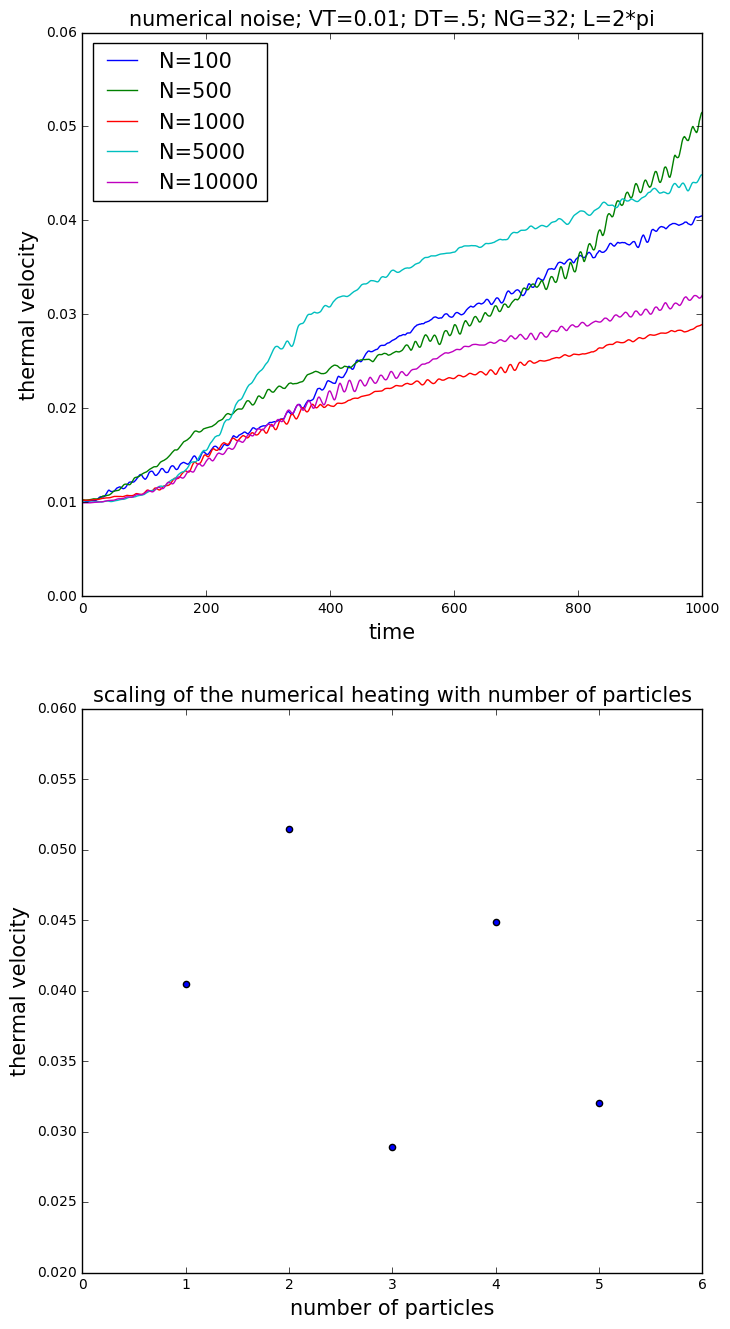

In [18]:
# Exercise 1
# Q: What is the scaling of the numerical noise with the number of particles?
# A: 

Y = []
numerical_noise = []

for i in N:
    vt = PIC(i,NG[1],DT[2])[1]
    Y.append(vt)
    numerical_noise.append(vt[-1])
    

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,16))
X = np.linspace(0,(NT-1)*0.5,NT)
ax1.plot(X, Y[0], label='N=100')
ax1.plot(X, Y[1], label='N=500')
ax1.plot(X, Y[2], label='N=1000')
ax1.plot(X, Y[3], label='N=5000')
ax1.plot(X, Y[4], label='N=10000')
ax1.set_xlabel("time", fontsize=15)
ax1.set_ylabel("thermal velocity", fontsize=15)
ax1.set_title("numerical noise; VT=0.01; DT=.5; NG=32; L=2*pi", fontsize=15)
ax1.legend(loc=2, fontsize=15)

X_N = np.linspace(1,5,5)
print numerical_noise
ax2.scatter(X_N, numerical_noise)
ax2.set_xlabel("number of particles", fontsize=15)
ax2.set_ylabel("thermal velocity", fontsize=15)
#ax2.set_ylim(0.014,0.02)
ax2.set_title("scaling of the numerical heating with number of particles", fontsize=15)
fig.savefig('NN.jpeg')

(-0.1, 0.1)

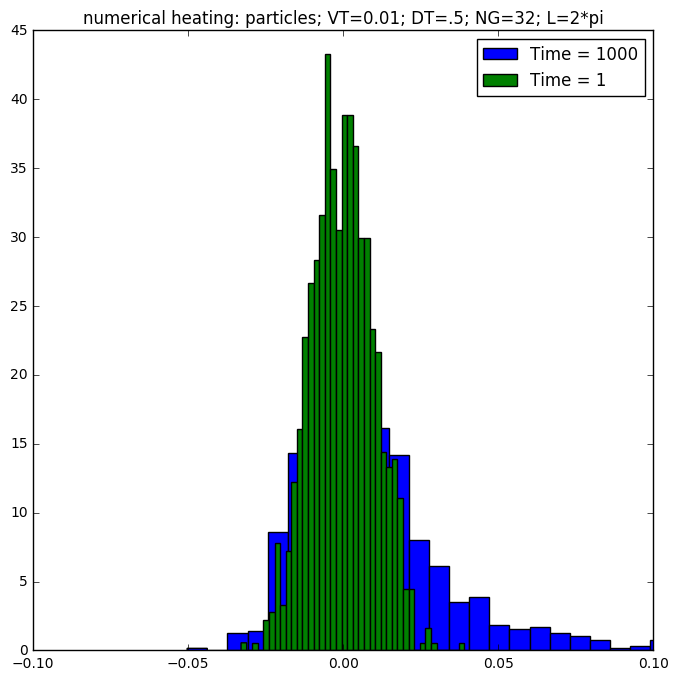

In [145]:
Y2 = []
V_0 = []
for i in N:
    v = PIC(i,NG,DT)[0]
    v0 = PIC(i,NG,DT)[2]
    V_0.append(v0)
    Y2.append(v)

#fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,24))
fig, ax1 = plt.subplots(1,1, figsize=(8,8))
#count, bins, ignored = ax1.hist(vp, normed=True, bins=40)
ax1.set_title("numerical heating: particles; VT=0.01; DT=.5; NG=32; L=2*pi")
ax1.hist(Y2[0], normed=True, bins=40, label='Time = 1000')
ax1.hist(V_0[0], normed=True, bins=40, label='Time = 1')
ax1.legend(loc='upper right')
ax1.set_xlim(-0.1,0.1)
#ax2.hist(Y2[2], normed=True, bins=40, label='Time = 1000')
#ax2.hist(V_0[2], normed=True, bins=40, label='Time = 1')
#ax2.set_title("numerical heating: particles; VT=0.01; DT=.5; NG=32; L=2*pi")
#ax2.legend(loc='upper right')
#ax3.hist(Y2[4], normed=True, bins=40, label='Time = 1000')
#ax3.hist(V_0[4], normed=True, bins=40, label='Time = 1')
#ax3.set_title("numerical heating: particles; VT=0.01; DT=.5; NG=32; L=2*pi")
#ax3.legend(loc='upper right')

In [ ]:
conservation = [3,4,5,6]

X = np.linspace(0,NT-1,NT)

Energy = []

for i in conservation:

    for j in range(len(NG)):
        Ee = PIC(N[1],NG[j],DT[2])[i]
        Energy.append(Ee)


fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,32))
ax1.plot(X,Energy[0], label='NG=24')
ax1.plot(X,Energy[1], label='NG=32')
ax1.plot(X,Energy[2], label='NG=40')
ax1.plot(X,Energy[3], label='NG=48')
ax1.set_title('History of total Electric energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)
    
ax2.plot(X,Energy[4], label='NG=24')
ax2.plot(X,Energy[5], label='NG=32')
ax2.plot(X,Energy[6], label='NG=40')
ax2.plot(X,Energy[7], label='NG=48')
ax2.set_title('History of total Kinetic energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax2.legend(loc=2, fontsize=15)

ax3.plot(X,Energy[8], label='NG=24')
ax3.plot(X,Energy[9], label='NG=32')
ax3.plot(X,Energy[10], label='NG=40')
ax3.plot(X,Energy[11], label='NG=48')
ax3.set_title('History of total Total energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax3.legend(loc=2, fontsize=15)

ax4.plot(X,Energy[12], label='NG=24')
ax4.plot(X,Energy[13], label='NG=32')
ax4.plot(X,Energy[14], label='NG=40')
ax4.plot(X,Energy[15], label='NG=48')
ax4.set_title('History of Total energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax4.legend(loc=2, fontsize=15)

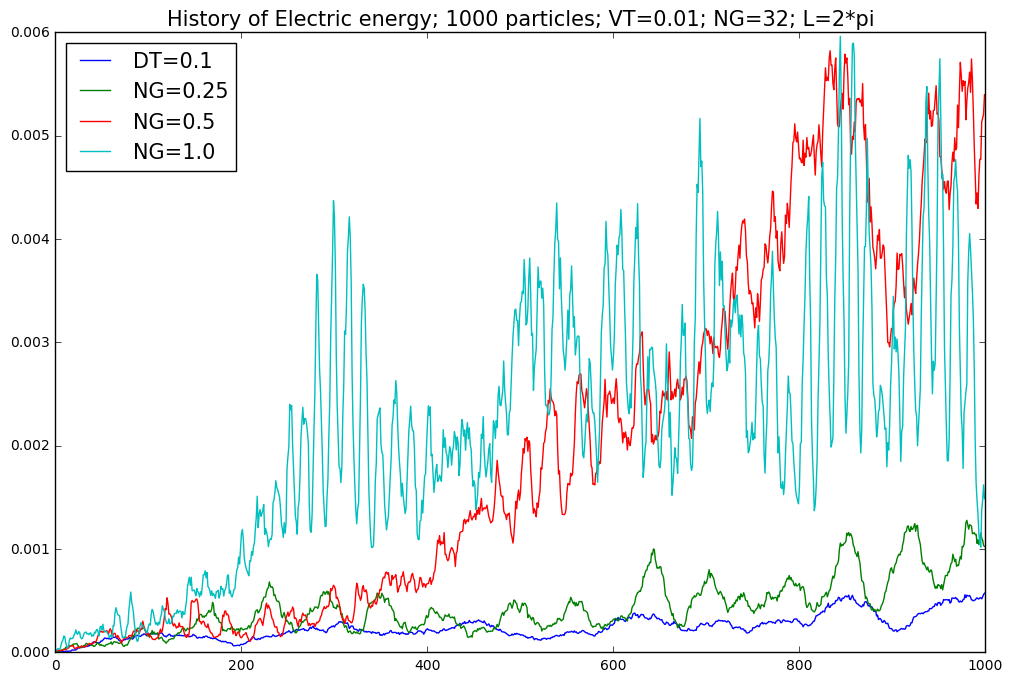

In [167]:
EE2 = []
for j in range(len(DT)):
    Ee2 = PIC(i,NG[1],DT[j])[3]
    EE2.append(Ee2)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,EE2[0], label='DT=0.1')
ax1.plot(X,EE2[1], label='DT=0.25')
ax1.plot(X,EE2[2], label='DT=0.5')
ax1.plot(X,EE2[3], label='DT=1.0')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of Electric energy; 1000 particles; VT=0.01; NG=32; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

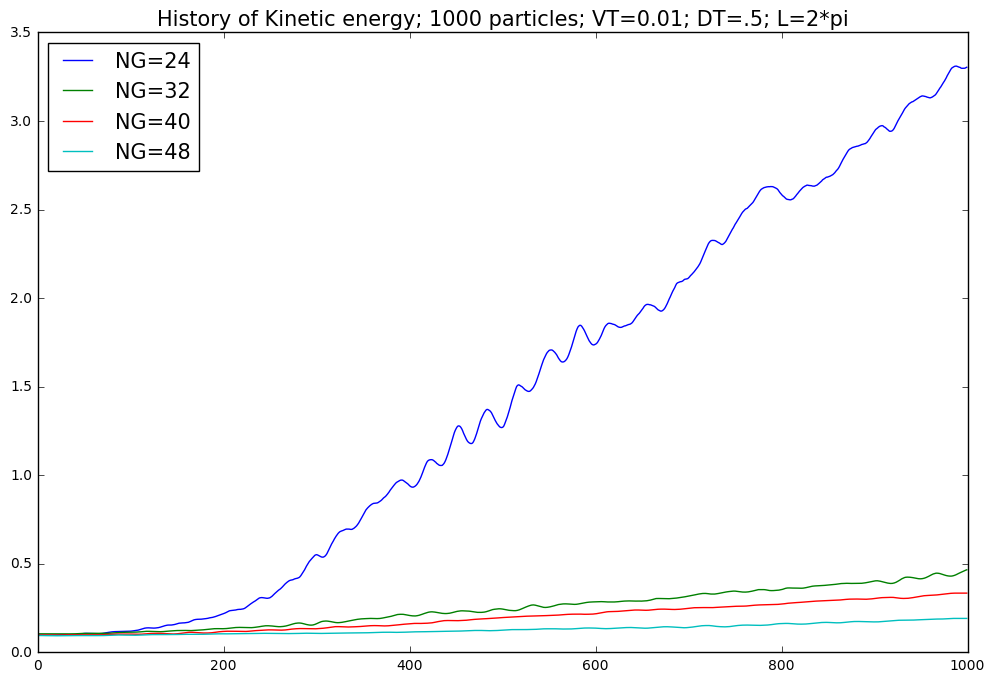

In [168]:
KE = []
for j in range(len(NG)):
    Ke = PIC(i,NG[j],DT[2])[4]
    KE.append(Ke)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,KE[0], label='NG=24')
ax1.plot(X,KE[1], label='NG=32')
ax1.plot(X,KE[2], label='NG=40')
ax1.plot(X,KE[3], label='NG=48')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of Kinetic energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

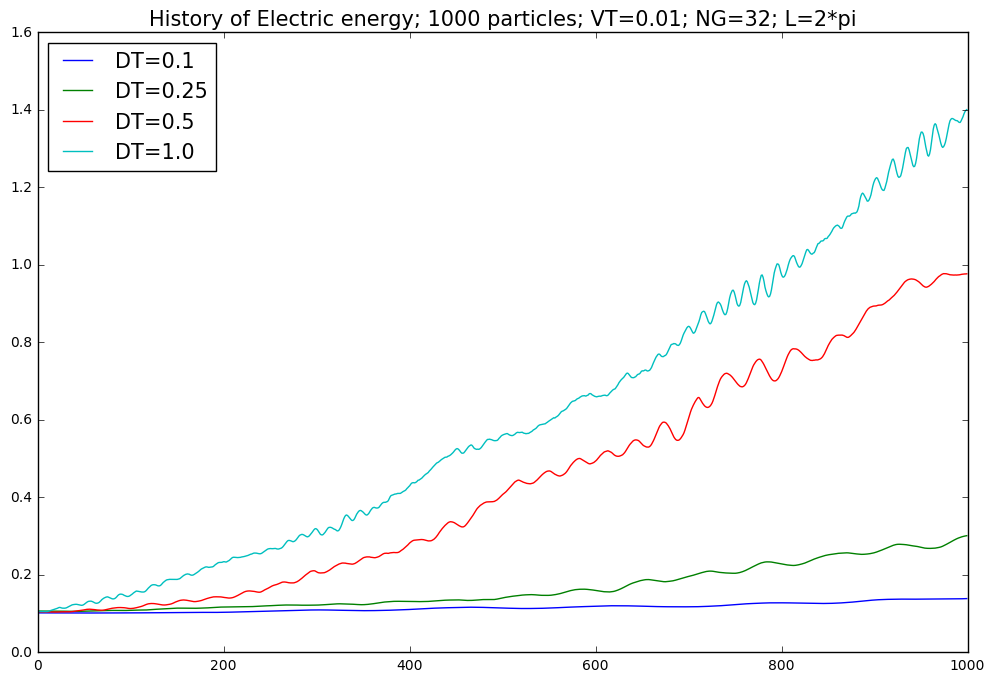

In [170]:
KE2 = []
for j in range(len(DT)):
    Ke2 = PIC(i,NG[1],DT[j])[4]
    KE2.append(Ke2)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,KE2[0], label='DT=0.1')
ax1.plot(X,KE2[1], label='DT=0.25')
ax1.plot(X,KE2[2], label='DT=0.5')
ax1.plot(X,KE2[3], label='DT=1.0')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of Electric energy; 1000 particles; VT=0.01; NG=32; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

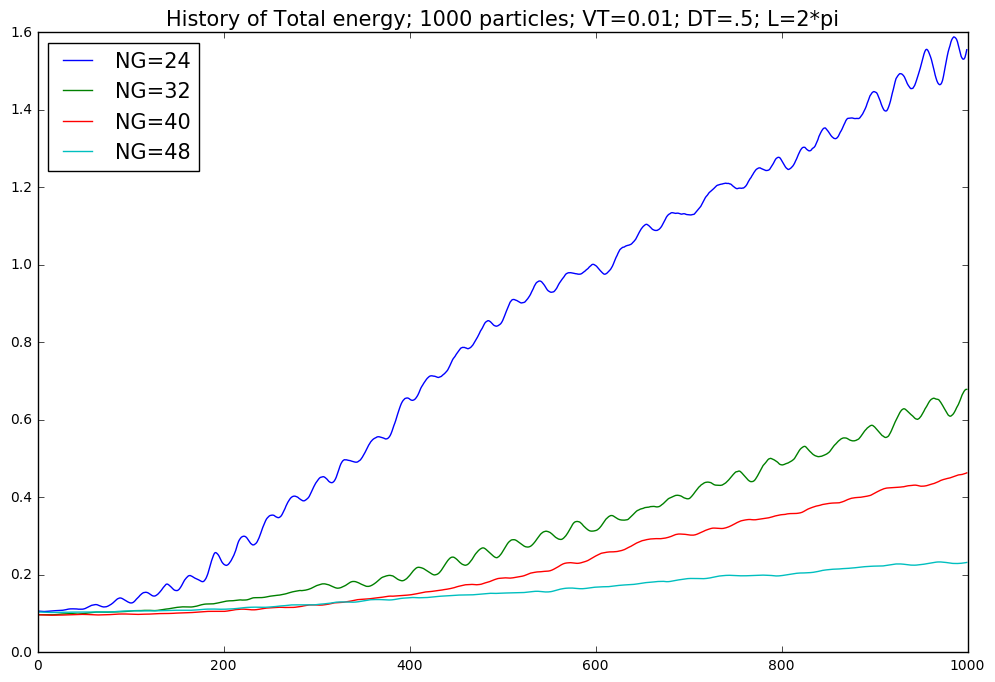

In [174]:
ET = []
for j in range(len(NG)):
    Et = PIC(i,NG[j],DT[2])[5]
    ET.append(Et)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,ET[0], label='NG=24')
ax1.plot(X,ET[1], label='NG=32')
ax1.plot(X,ET[2], label='NG=40')
ax1.plot(X,ET[3], label='NG=48')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of Total energy; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

In [ ]:
ET2 = []
for j in range(len(DT)):
    Et2 = PIC(i,NG[1],DT[j])[5]
    ET2.append(Et2)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,ET2[0], label='DT=0.1')
ax1.plot(X,ET2[1], label='DT=0.25')
ax1.plot(X,ET2[2], label='DT=0.5')
ax1.plot(X,ET2[3], label='DT=1.0')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of Total energy; 1000 particles; VT=0.01; NG=32; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

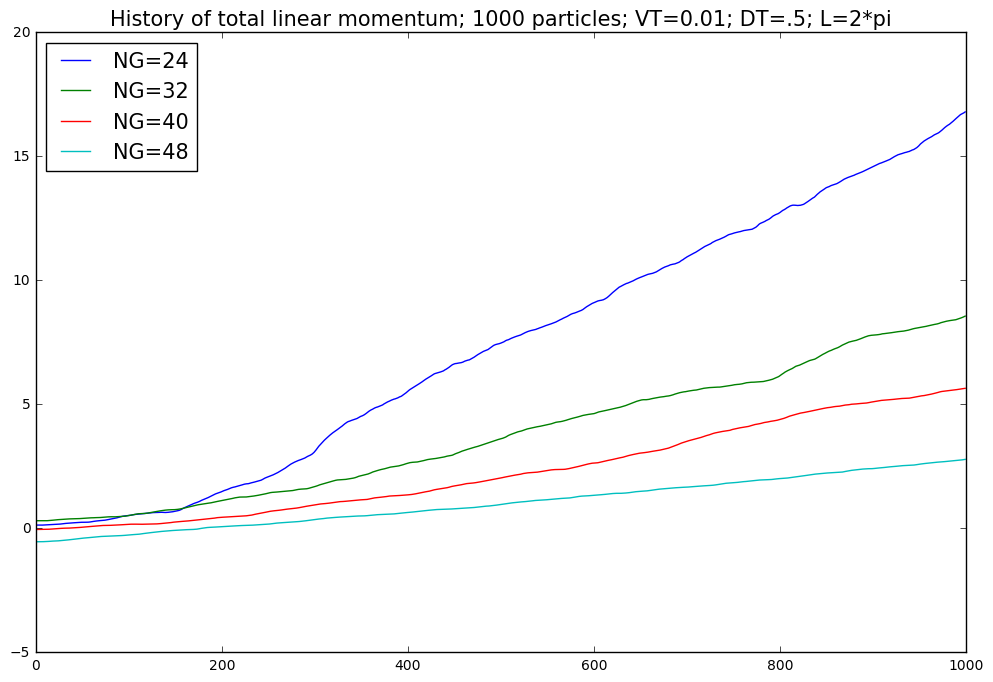

In [172]:
PT = []
for j in range(len(NG)):
    Pt = PIC(i,NG[j],DT[2])[6]
    PT.append(Pt)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,PT[0], label='NG=24')
ax1.plot(X,PT[1], label='NG=32')
ax1.plot(X,PT[2], label='NG=40')
ax1.plot(X,PT[3], label='NG=48')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of total linear momentum; 1000 particles; VT=0.01; DT=.5; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)

In [ ]:
PT2 = []
for j in range(len(DT)):
    Pt2 = PIC(i,NG[1],DT[j])[6]
    PT2.append(Pt2)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.plot(X,PT2[0], label='DT=0.1')
ax1.plot(X,PT2[1], label='DT=0.25')
ax1.plot(X,PT2[2], label='DT=0.5')
ax1.plot(X,PT2[3], label='DT=1.0')
#ax1.set_ylim(-0.0005,0.008)
ax1.set_title('History of total linear momentum; 1000 particles; VT=0.01; NG=32; L=2*pi', fontsize=15)
ax1.legend(loc=2, fontsize=15)